## INFOSYS 722 Assignement Iteration 4 - Sub-iteration 2

In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math

In [3]:
spark = SparkSession.builder.appName('infosys722-i4-i2').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/12 09:10:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
selected_products = spark.read.options(compression='gzip').format('parquet').load('./Cleaned Datasets/products_v001')
integrated_purchase_detail = spark.read.options(compression='gzip').format('parquet').load(
    './Ready Datasets/purchase_detail_v001')
integrated_sales = spark.read.options(compression='gzip').format('parquet').load(
    './Ready Datasets/sales_v001')

In [5]:
period = 60

In [6]:
sales_frequency = integrated_sales.groupBy('Brand').agg(
    F.count('Brand').alias('count')).withColumn('Frequency', F.col('count') / period)

In [7]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor, LinearRegression, RandomForestRegressor
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, GBTClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator

import seaborn as sns


In [8]:
clustering = Pipeline(stages = [
    VectorAssembler(inputCols=['Frequency'], outputCol='features'), 
    KMeans(k=3, seed=13)])
cluster_model = clustering.fit(sales_frequency)    

In [9]:
result = cluster_model.transform(sales_frequency)

<AxesSubplot:xlabel='prediction', ylabel='Frequency'>

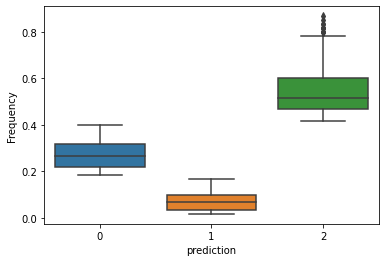

In [10]:
sns.boxplot(x='prediction', y='Frequency', data=result.toPandas())

In [11]:
evaluator = ClusteringEvaluator(metricName='silhouette',  
                                distanceMeasure='squaredEuclidean')
evaluator.evaluate(result)

0.7969227246756405

In [12]:
result.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 2467|
|         2|  394|
|         0|  937|
+----------+-----+



In [13]:
daily_avg_sales = integrated_sales.groupBy('Brand').agg(
    F.sum('SalesQuantity').alias('TotalSales')).withColumn(
    'DailyAverageSales', F.col('TotalSales') / period)

In [14]:
clustering = Pipeline(stages = [
    VectorAssembler(inputCols=['DailyAverageSales'], outputCol='features'), 
    KMeans(k=3, seed=13)])
cluster_model = clustering.fit(daily_avg_sales)    

<AxesSubplot:xlabel='prediction', ylabel='DailyAverageSales'>

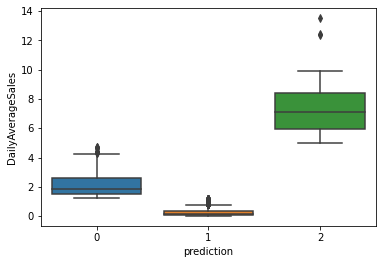

In [15]:
result = cluster_model.transform(daily_avg_sales)
sns.boxplot(x='prediction', y='DailyAverageSales', data=result.toPandas())

In [16]:
evaluator = ClusteringEvaluator(metricName='silhouette',  
                                distanceMeasure='squaredEuclidean')
evaluator.evaluate(result)

0.9221945216287653

In [17]:
result.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 3491|
|         2|   28|
|         0|  279|
+----------+-----+



In [18]:
weekly_sales = integrated_sales.withColumn('Week', F.weekofyear(F.col('SalesDate'))).groupBy(
    ['Brand', 'Week']).agg(
    F.sum('SalesQuantity').alias('GroupedSales'), 
    F.mean('SalesPrice').alias('MeanPrice'),
    F.mean('PurchasePrice').alias('MeanPurchasePrice')
)

In [19]:
weekly_frequency = weekly_sales.groupBy('Brand').agg(F.count('Brand').alias('WeeklyFrequency'))

In [20]:
weekly_frequency.summary().show()

+-------+------------------+-----------------+
|summary|             Brand|  WeeklyFrequency|
+-------+------------------+-----------------+
|  count|              3798|             3798|
|   mean|15094.384149552396|4.983412322274882|
| stddev|13184.954924953849|2.872221950864614|
|    min|               100|                1|
|    25%|            3919.0|                2|
|    50%|            8895.0|                5|
|    75%|           23764.0|                8|
|    max|               999|               10|
+-------+------------------+-----------------+



In [21]:
cutoff = 10*3/4
selected_brand = weekly_frequency.where(F.col('WeeklyFrequency') > cutoff)

In [22]:
selected_data = selected_brand.join(weekly_sales, on = 'Brand', how = 'left').join(
    selected_products, on ='Brand', how = 'left')

In [23]:
def evaluate_regression_model(result, labelCol, predictionCol='prediction', metrics = ['rmse', 'mse', 'mae', 'r2']):
    results = [(metric, 
                RegressionEvaluator(labelCol=labelCol, metricName=metric, predictionCol=predictionCol).evaluate(result)) 
               for metric in metrics]
    for metric, result in results:
        print(f'{metric}: {result}')
    return dict(results)

def evaluate_classification_model(result, labelCol, predictionCol='prediction', metrics = ['f1', 'accuracy']):
    results = [(metric, 
                MulticlassClassificationEvaluator(
                    labelCol=labelCol, metricName=metric, predictionCol=predictionCol).evaluate(result)) 
               for metric in metrics]
    for metric, v in results:
        print(f'{metric}: {v}')
    return dict(results)
    
def get_string_indexers(dataframe, suffix='_index'):
    indexers = []
    for feature, dtype in dataframe.dtypes:
        if dtype == 'string':
            indexers.append(StringIndexer(inputCol=feature, outputCol=feature + suffix))
    return indexers

def generate_baseline(dataframe, target):
    target_mean = dataframe.agg(F.mean(target)).collect()[0][0]
    return dataframe.withColumn('baseline_prediction', F.lit(target_mean))

def balance(dataframe, target, size=None):
    categories = dataframe.groupBy(target).agg(F.count(target).alias('count'))
    if size is None:
        size = int(categories.agg(F.mean('count')).collect()[0][0])
    balanced_df = spark.createDataFrame([], dataframe.schema)
    for category, count in categories.collect():
        if count > size:
            sample = dataframe.where(F.col(target) == category).orderBy(F.rand(13)).limit(size)
        else:
            ratio = math.ceil(size/count)
            sample = dataframe.where(F.col(target) == category).withColumn(
                'dummy', F.explode(F.array([F.lit(i) for i in range(ratio)]))).drop('dummy').orderBy(F.rand(13)).limit(size)
        balanced_df = balanced_df.unionAll(sample)
    return balanced_df

def print_evaluation(model, train, test, target, transformer, evaluate_function=evaluate_regression_model):
    print('Training data evaluation metrics:')
    result = model.transform(transformer.transform(train))
    evaluate_function(result, target)

    print('Testing data evaluation metrics:')
    result = model.transform(transformer.transform(test))
    evaluate_function(result, target)

def print_feature_importance(model, train, rounding=6):
    attrs = train.schema["features"].metadata['ml_attr']['attrs']
    feature_names = []
    for key, feature_list in attrs.items():
        feature_names = feature_names + feature_list
    feature_importances = [(f['name'], float(round(model.featureImportances[f['idx']], rounding))) for f in feature_names]
    spark.createDataFrame(feature_importances, ['feature', 'importance']).orderBy('importance', ascending=False).show()

In [24]:
selected_data.select('GroupedSales').summary().show()

+-------+------------------+
|summary|      GroupedSales|
+-------+------------------+
|  count|              8638|
|   mean| 8.055105348460291|
| stddev|14.133847060371124|
|    min|                 1|
|    25%|                 2|
|    50%|                 4|
|    75%|                 9|
|    max|               433|
+-------+------------------+



{'whiskers': [<matplotlib.lines.Line2D at 0x7f4a22ce39a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f4a22bc78e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f4a22ce3b20>],
 'medians': [<matplotlib.lines.Line2D at 0x7f4a22bc4910>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f4a22bc54e0>],
 'means': []}

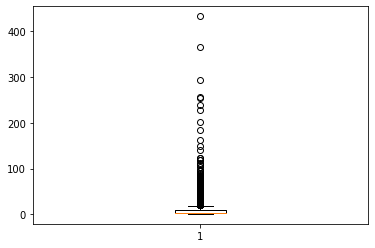

In [25]:
plt.boxplot(selected_data.toPandas()['GroupedSales'])

+-------+-----------------+
|summary|     GroupedSales|
+-------+-----------------+
|  count|             8067|
|   mean|5.503904797322424|
| stddev|4.687780103195881|
|    min|                1|
|    25%|                2|
|    50%|                4|
|    75%|                7|
|    max|               22|
+-------+-----------------+



{'whiskers': [<matplotlib.lines.Line2D at 0x7f4a22be2b00>,
 'caps': [<matplotlib.lines.Line2D at 0x7f4a22be03a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f4a22be1e10>],
 'medians': [<matplotlib.lines.Line2D at 0x7f4a22be36a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f4a22be37c0>],
 'means': []}

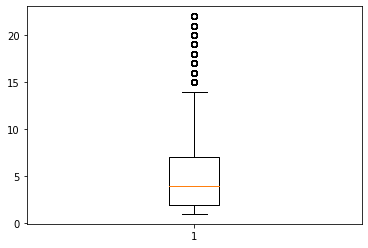

In [26]:
def remove_extreme_by_z_scores(dataframe, column, threshold = 1):
    mean, std = dataframe.agg(F.mean(column), F.stddev(column)).collect()[0]
    dataframe = dataframe.withColumn('z_scores', (F.col(column) - mean) / std)
    return dataframe.where(F.col('z_scores') <= threshold).drop('z_scores')
selected_data = remove_extreme_by_z_scores(selected_data, 'GroupedSales')
selected_data.select('GroupedSales').summary().show()
plt.boxplot(selected_data.toPandas()['GroupedSales'])

In [27]:
selected_data.printSchema()

root
 |-- Brand: string (nullable = true)
 |-- WeeklyFrequency: long (nullable = false)
 |-- Week: integer (nullable = true)
 |-- GroupedSales: long (nullable = true)
 |-- MeanPrice: double (nullable = true)
 |-- MeanPurchasePrice: double (nullable = true)
 |-- Price: float (nullable = true)
 |-- Size: string (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Classification: string (nullable = true)
 |-- PurchasePrice: float (nullable = true)
 |-- VendorNumber: string (nullable = true)



In [28]:
weekly_average = selected_data.groupBy('Brand').agg(F.mean('GroupedSales').alias('WeeklyMeanSales'))

In [29]:
selected_data = selected_data.join(weekly_average, on = 'Brand', how = 'left')

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 1230|
|         2| 2341|
|         0| 4496|
+----------+-----+



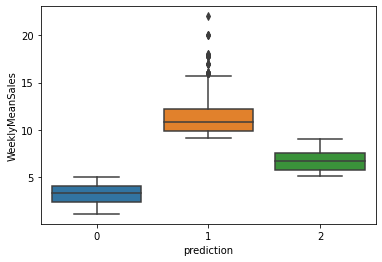

In [30]:
clustering = Pipeline(stages = [
    VectorAssembler(inputCols=['WeeklyMeanSales'], outputCol='features'), 
    KMeans(k=3, seed=13)])
cluster_model = clustering.fit(selected_data)    
result = cluster_model.transform(selected_data)
sns.boxplot(x='prediction', y='WeeklyMeanSales', data=result.toPandas())
result.groupBy('prediction').count().show()

In [31]:
selected_data = cluster_model.transform(selected_data).drop('features').withColumnRenamed('prediction', 'Cluster')
selected_data.printSchema()

root
 |-- Brand: string (nullable = true)
 |-- WeeklyFrequency: long (nullable = false)
 |-- Week: integer (nullable = true)
 |-- GroupedSales: long (nullable = true)
 |-- MeanPrice: double (nullable = true)
 |-- MeanPurchasePrice: double (nullable = true)
 |-- Price: float (nullable = true)
 |-- Size: string (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Classification: string (nullable = true)
 |-- PurchasePrice: float (nullable = true)
 |-- VendorNumber: string (nullable = true)
 |-- WeeklyMeanSales: double (nullable = true)
 |-- Cluster: integer (nullable = false)



In [34]:
transformation_pipeline = Pipeline(stages=get_string_indexers(selected_data) + [
    VectorAssembler(inputCols=[
        'MeanPrice', 'Volume', 'Week', 'MeanPurchasePrice', 'Cluster',
        'Size_index', 'Classification_index', 'VendorNumber_index'], 
                    outputCol='features')
])

sales_transformer = transformation_pipeline.fit(selected_data)

test_data_size = 1 / (math.sqrt(7) + 1)
print(f'Test data size is {test_data_size}')
train, test = selected_data.randomSplit([1-test_data_size, test_data_size], seed=13)

rfr = RandomForestRegressor(maxDepth=10, numTrees = 20, labelCol='GroupedSales', featuresCol='features', maxBins=256)
model = rfr.fit(sales_transformer.transform(train))
print('Baseline performance:')
evaluate_regression_model(generate_baseline(test, 'GroupedSales'), 'GroupedSales', predictionCol='baseline_prediction', metrics=['mse', 'r2'])
print('Training Performance:')
result = model.transform(sales_transformer.transform(train))
_ = evaluate_regression_model(result, 'GroupedSales', metrics=['mse', 'r2'])
print('Testing Performance:')
result = model.transform(sales_transformer.transform(test))
_ = evaluate_regression_model(result, 'GroupedSales', metrics=['mse', 'r2'])

Test data size is 0.27429188517743175


23/10/12 09:13:29 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
23/10/12 09:13:30 WARN DAGScheduler: Broadcasting large task binary with size 1942.5 KiB


Baseline performance:
mse: 23.050993995685783
r2: -1.2878587085651816e-14
Training Performance:
mse: 8.21675101369247
r2: 0.6190433979956551
Testing Performance:
mse: 12.816066624267114
r2: 0.4440124088936933


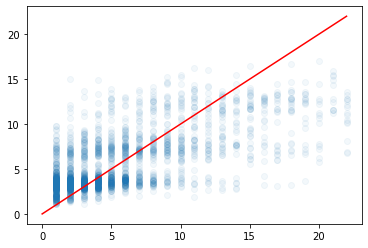

In [36]:
dsp_df = result.toPandas()
plt.scatter(dsp_df['GroupedSales'], dsp_df['prediction'], alpha=0.05)
plt.plot(range(0,23), c='r')
plt.show()

In [39]:
print_feature_importance(model, sales_transformer.transform(train))

+--------------------+----------+
|             feature|importance|
+--------------------+----------+
|             Cluster|   0.54737|
|                Week|  0.149468|
|  VendorNumber_index|  0.117139|
|   MeanPurchasePrice|  0.075063|
|           MeanPrice|  0.060635|
|          Size_index|  0.031961|
|              Volume|  0.014467|
|Classification_index|  0.003896|
+--------------------+----------+

